Imports:

In [1]:
import cv2
import numpy as np
import torch
from torchvision import transforms
import time
import torch.nn as nn
import torch.optim as optim
import os
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from PIL import Image 
import random
import json
from torchvision.models import resnet152
from torchvision.datasets import ImageFolder
from torch.utils import data
import matplotlib.pyplot as plt
from torchvision.models import resnet152 as Model
from torchvision.models.resnet import ResNet152_Weights as ModelW



In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU for training.")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU for training.")

Using GPU for training.


In [62]:
%run "../DL_notebooks/src/dataloading.ipynb"
%run "../DL_notebooks/src/training.ipynb"
%run "../DL_notebooks/src/evaluate.ipynb"
%run "../DL_notebooks/src/visualizations.ipynb"
%run "../DL_notebooks/model_architectures.ipynb"

Data loaded and split into training, validation and testing datasets


In [4]:
def update_current_model(json_file, new_model_name):
    # Load the JSON data from the file
    with open(json_file, 'r') as file:
        data = json.load(file)

    # Update the current-model value
    data['current-model'] = new_model_name

    # Save the updated JSON data back to the file
    with open(json_file, 'w') as file:
        json.dump(data, file, indent=4)
json_file_path = '../DL_notebooks/configs/model_configs.json'

In [5]:
update_current_model(json_file_path, "ResNet2")
model_config_file = open('../DL_notebooks/configs/model_configs.json')
model_configs = json.load(model_config_file)
current_model_configs = model_configs[model_configs['current-model']]

epochs = current_model_configs['epoch-count']

match model_configs['current-model']:
    case 'ResNet2':
        model = MRI_ResNet2
match current_model_configs['loss-function']:
    case 'cross-entropy':
        criterion = nn.CrossEntropyLoss()
    case _:
        criterion = nn.CrossEntropyLoss()
match current_model_configs['optimizer']:
    case 'adam':
        optimizer = optim.Adam
    case 'adamW':
        optimizer = optim.AdamW
    case _:
        optimizer = optim.Adam

model = model(**current_model_configs['model-hyperparameters']).to(device)
optimizer = optimizer(model.parameters(), lr=current_model_configs['optimizer-lr'])

In [6]:
for epoch in tqdm(range(epochs), desc="Training", unit="epoch"):
    train_loss, train_accuracy, train_labels2, train_preds2 = train(model, train_loader=train_loader,optimizer=optimizer, criterion=criterion, device=device)
    val_loss, val_accuracy, val_labels2, val_preds2 = evaluate(model, val_loader, criterion=criterion, device=device)

    tqdm.write(
        f"Epoch [{epoch + 1}/{epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Train Accuracy: {train_accuracy * 100:.2f}% "
        f"Validation Loss: {val_loss:.4f} "
        f"Validation Accuracy: {val_accuracy * 100:.2f}%"
    )

Training:  10%|█         | 1/10 [03:08<28:18, 188.77s/epoch]

Epoch [1/10] Train Loss: 0.9855 Train Accuracy: 68.77% Validation Loss: 0.6940 Validation Accuracy: 80.13%


Training:  20%|██        | 2/10 [06:21<25:28, 191.07s/epoch]

Epoch [2/10] Train Loss: 0.4342 Train Accuracy: 89.77% Validation Loss: 0.3201 Validation Accuracy: 91.92%


Training:  30%|███       | 3/10 [09:30<22:10, 190.12s/epoch]

Epoch [3/10] Train Loss: 0.2229 Train Accuracy: 96.02% Validation Loss: 0.2466 Validation Accuracy: 93.54%


Training:  40%|████      | 4/10 [12:41<19:03, 190.63s/epoch]

Epoch [4/10] Train Loss: 0.1071 Train Accuracy: 98.82% Validation Loss: 0.2208 Validation Accuracy: 92.73%


Training:  50%|█████     | 5/10 [15:54<15:56, 191.37s/epoch]

Epoch [5/10] Train Loss: 0.0724 Train Accuracy: 99.57% Validation Loss: 0.1771 Validation Accuracy: 94.83%


Training:  60%|██████    | 6/10 [19:07<12:47, 191.85s/epoch]

Epoch [6/10] Train Loss: 0.0524 Train Accuracy: 99.84% Validation Loss: 0.1701 Validation Accuracy: 94.67%


Training:  70%|███████   | 7/10 [22:20<09:36, 192.17s/epoch]

Epoch [7/10] Train Loss: 0.0438 Train Accuracy: 99.84% Validation Loss: 0.1967 Validation Accuracy: 93.21%


Training:  80%|████████  | 8/10 [25:33<06:24, 192.46s/epoch]

Epoch [8/10] Train Loss: 0.0357 Train Accuracy: 100.00% Validation Loss: 0.1800 Validation Accuracy: 94.51%


Training:  90%|█████████ | 9/10 [28:46<03:12, 192.79s/epoch]

Epoch [9/10] Train Loss: 0.0267 Train Accuracy: 100.00% Validation Loss: 0.1807 Validation Accuracy: 94.18%


Training: 100%|██████████| 10/10 [31:54<00:00, 191.46s/epoch]

Epoch [10/10] Train Loss: 0.0326 Train Accuracy: 99.89% Validation Loss: 0.1746 Validation Accuracy: 95.15%


In [7]:

data_path = "..\Data"
class_names = [folder_name for folder_name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder_name))]


In [63]:

# # Instantiate the GradCAM model and set the device
# gradcam_model = GradCAMModel(model)
# gradcam_model.to(device)

# # Rest of the code remains mostly unchanged
# num_images = len(test_loader.dataset)
# random_index = random.randint(0, num_images - 1)

# # set the evaluation mode
# _ = gradcam_model.eval()
# num_images_to_process = 10
# available_indices = list(range(len(test_loader)))

# for _ in range(num_images_to_process):
#     specified_index = random.sample(available_indices, 1)[0]
#     available_indices.remove(specified_index)

#     for idx, (images, labels) in enumerate(test_loader):
#         if idx == specified_index:
#             label_of_image = labels[0]
#             break

#     # Assuming img has a shape of [batch_size, channels, height, width]
#     img, _ = next(iter(test_loader))
#     img = img.to(device)
#     img = img[specified_index].unsqueeze(0) 
#     # If img has batch dimension, select a single image from it
#     img.requires_grad = True

#     print(img.shape)

#     # Forward pass through GradCAMModel
#     pred = gradcam_model(img)
#     predicted_class = pred.argmax(dim=1)

#     # No need to compute loss or gradients manually

#     # Get the activations and gradients from GradCAMModel
#     activations = gradcam_model.get_activations(img)
#     gradients = gradcam_model.get_gradient()

#     # GradCAM computation
#     pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
#     weighted_activations = torch.zeros(activations.size(1))

#     for i in range(activations.size(1)):
#         weighted_activations[i] = torch.sum(pooled_gradients[i] * activations[:, i, :, :])

#     heatmap = weighted_activations.unsqueeze(0)
#     heatmap = torch.nn.functional.relu(heatmap)

#     # Upsample the heatmap to match the input image size
#     heatmap = torch.nn.functional.interpolate(heatmap.unsqueeze(0), size=(img.size(2), img.size(3)), mode='bilinear', align_corners=False)
#     heatmap = heatmap.squeeze().cpu().detach().numpy()
#     heatmap = np.maximum(heatmap, 0)
#     heatmap /= np.max(heatmap)

#     # Visualization part (rest of the code)
#     # Create heatmap as PIL image
#     heatmap_pil = Image.fromarray(np.uint8(plt.cm.jet(heatmap) * 255))

#     # Convert the tensor image to a PIL image
#     img_pil = transforms.ToPILImage()(img.squeeze(0).cpu())

#     # Resize heatmap to match the image size
#     heatmap_resized = heatmap_pil.resize((img_pil.width, img_pil.height), Image.ANTIALIAS)

#     # Blend the heatmap onto the image with transparency
#     blended = Image.blend(img_pil.convert("RGBA"), heatmap_resized.convert("RGBA"), alpha=0.5)

#     # Display the superimposed image
#     predicted_label = predicted_class[0]
#     predicted_label = class_names[predicted_label]
#     true_label = class_names[label_of_image]

#     plt.imshow(blended)
#     plt.title(f"Predicted Class: {predicted_label} | True Class: {true_label}")
#     plt.axis('off')
#     plt.show()



torch.Size([1, 3, 256, 256])
torch.Size([1, 3])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3 and 2048x4)

In [67]:
class ResNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNet, self).__init__()
        self.model = Model(weights=ModelW.IMAGENET1K_V1)
        self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=num_classes)

        # Re-organize the layers for feature extraction
        self.features = nn.Sequential(
            self.model.conv1,
            self.model.bn1,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            self.model.layer1,
            self.model.layer2,
            self.model.layer3,
            self.model.layer4
        )

        self.avgpool = self.model.avgpool
        self.classifier = self.model.fc
        self.gradient = None
        self.activations = None
    
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.activations
    
    def forward(self, x):
        x = self.features(x)
        if x.requires_grad:  # Register the hook only if gradients are needed
            h = x.register_hook(self.activations_hook)
            self.activations = x  # Store the activations for GradCAM
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
model = ResNet(num_classes=4)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

epochs = 10


for epoch in tqdm(range(epochs), desc="Training", unit="epoch"):
    train_loss, train_accuracy, train_labels2, train_preds2 = train(model, train_loader=train_loader,optimizer=optimizer, criterion=criterion, device=device)
    val_loss, val_accuracy, val_labels2, val_preds2 = evaluate(model, val_loader, criterion=criterion, device=device)

    tqdm.write(
        f"Epoch [{epoch + 1}/{epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Train Accuracy: {train_accuracy * 100:.2f}% "
        f"Validation Loss: {val_loss:.4f} "
        f"Validation Accuracy: {val_accuracy * 100:.2f}%"
    )

Training:  10%|█         | 1/10 [05:23<48:27, 323.06s/epoch]

Epoch [1/10] Train Loss: 0.8956 Train Accuracy: 65.70% Validation Loss: 4.1242 Validation Accuracy: 54.44%


Training:  20%|██        | 2/10 [10:33<42:04, 315.51s/epoch]

Epoch [2/10] Train Loss: 0.7555 Train Accuracy: 74.21% Validation Loss: 0.8097 Validation Accuracy: 74.31%


Training:  30%|███       | 3/10 [15:43<36:31, 313.03s/epoch]

Epoch [3/10] Train Loss: 0.5403 Train Accuracy: 80.02% Validation Loss: 0.8845 Validation Accuracy: 63.17%


Training:  40%|████      | 4/10 [20:51<31:05, 310.99s/epoch]

Epoch [4/10] Train Loss: 0.4962 Train Accuracy: 81.53% Validation Loss: 0.6724 Validation Accuracy: 76.74%


Training:  50%|█████     | 5/10 [25:56<25:43, 308.78s/epoch]

Epoch [5/10] Train Loss: 0.4592 Train Accuracy: 83.90% Validation Loss: 0.7819 Validation Accuracy: 73.67%


Training:  60%|██████    | 6/10 [30:51<20:16, 304.11s/epoch]

Epoch [6/10] Train Loss: 0.3933 Train Accuracy: 87.24% Validation Loss: 0.6432 Validation Accuracy: 74.96%


Training:  70%|███████   | 7/10 [35:29<14:46, 295.56s/epoch]

Epoch [7/10] Train Loss: 0.3764 Train Accuracy: 88.10% Validation Loss: 2.1097 Validation Accuracy: 47.33%


Training:  80%|████████  | 8/10 [40:07<09:40, 290.07s/epoch]

Epoch [8/10] Train Loss: 0.4363 Train Accuracy: 84.76% Validation Loss: 0.6832 Validation Accuracy: 77.38%


Training:  90%|█████████ | 9/10 [44:45<04:46, 286.41s/epoch]

Epoch [9/10] Train Loss: 0.3515 Train Accuracy: 89.71% Validation Loss: 0.5359 Validation Accuracy: 83.20%


Training: 100%|██████████| 10/10 [49:21<00:00, 296.16s/epoch]

Epoch [10/10] Train Loss: 0.6071 Train Accuracy: 79.48% Validation Loss: 0.8742 Validation Accuracy: 70.76%


620
14
Label of image at index 14: 0
tensor([2], device='cuda:0')


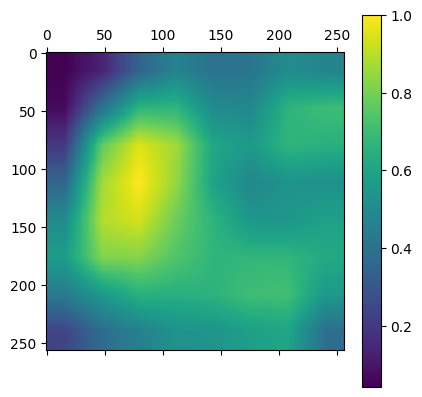

normal
glioma_tumor


C:\Users\gabeb\AppData\Local\Temp\ipykernel_10216\557073019.py:75: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  heatmap_resized = heatmap_pil.resize((img_pil.width, img_pil.height), Image.ANTIALIAS)


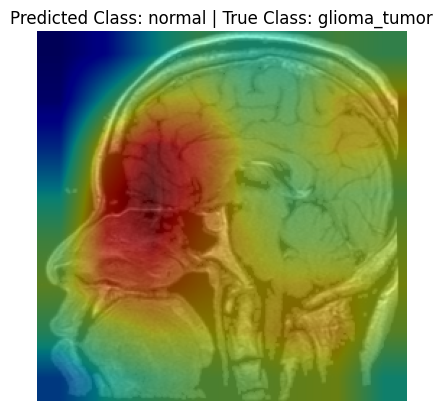

2
Label of image at index 2: 2
tensor([2], device='cuda:0')


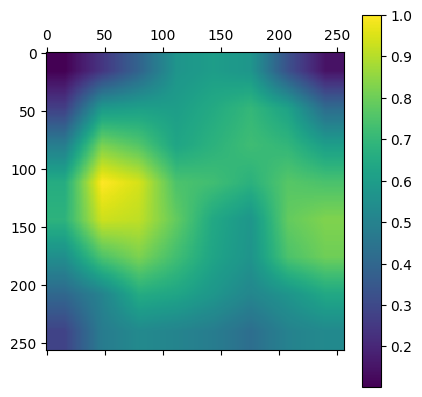

normal
normal


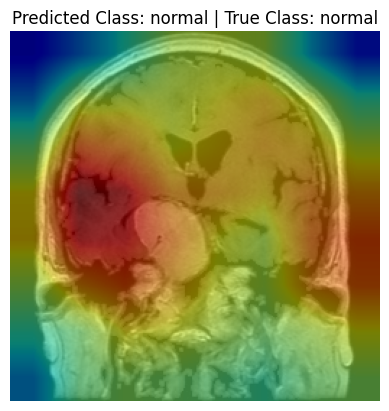

5
Label of image at index 5: 1
tensor([2], device='cuda:0')


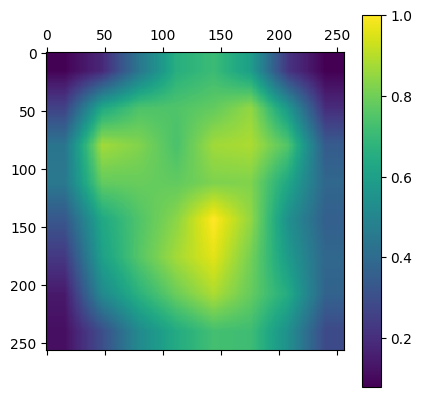

normal
meningioma_tumor


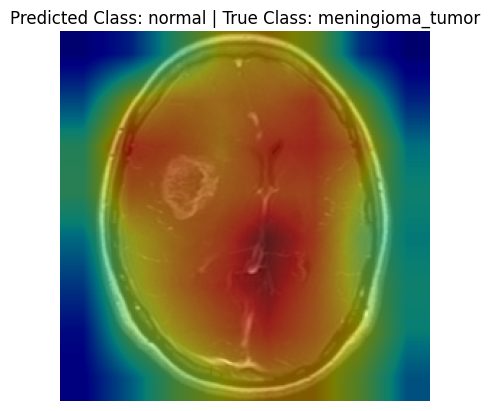

6
Label of image at index 6: 0
tensor([2], device='cuda:0')


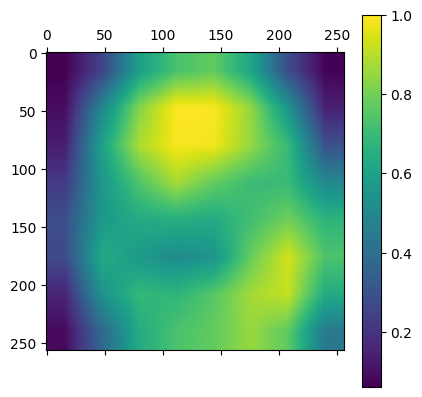

normal
glioma_tumor


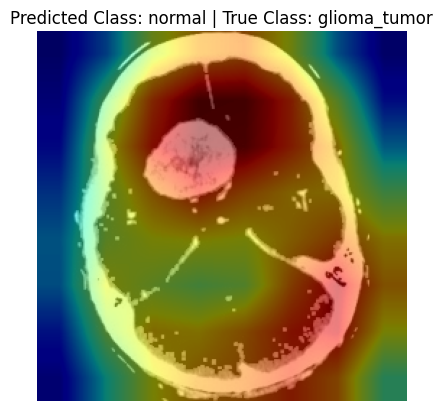

7
Label of image at index 7: 3
tensor([2], device='cuda:0')


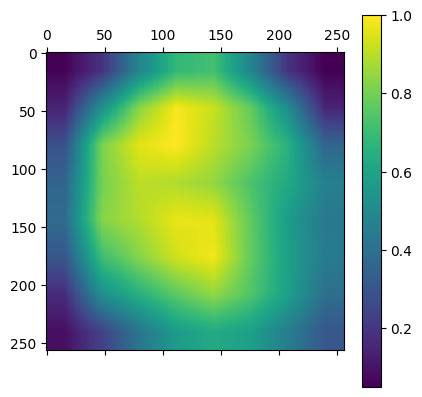

normal
pituitary_tumor


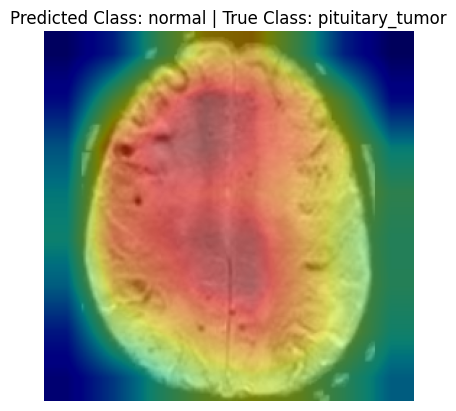

0
Label of image at index 0: 1
tensor([2], device='cuda:0')


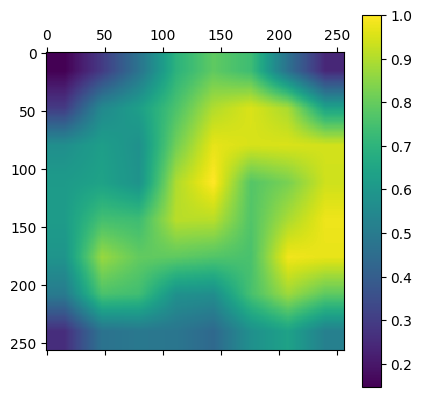

normal
meningioma_tumor


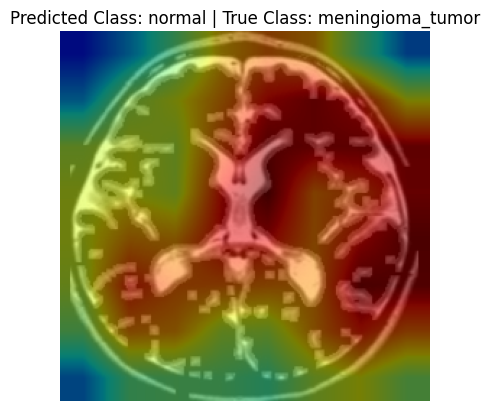

9
Label of image at index 9: 0
tensor([2], device='cuda:0')


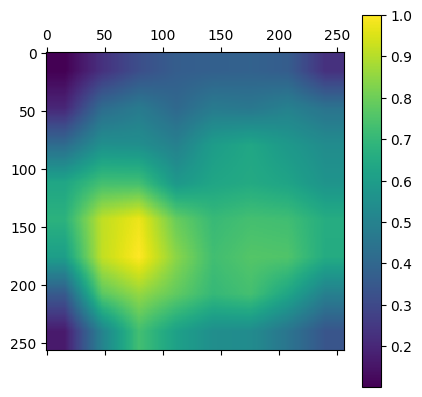

normal
glioma_tumor


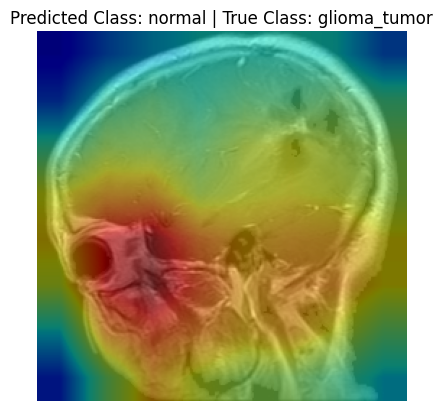

16
Label of image at index 16: 1
tensor([2], device='cuda:0')


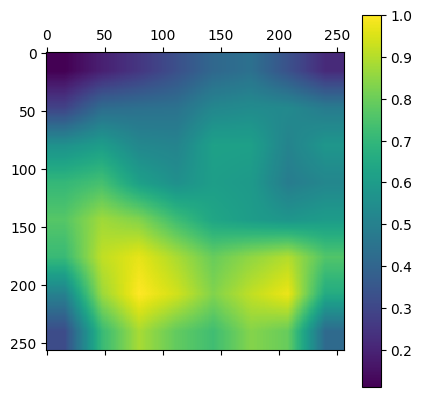

normal
meningioma_tumor


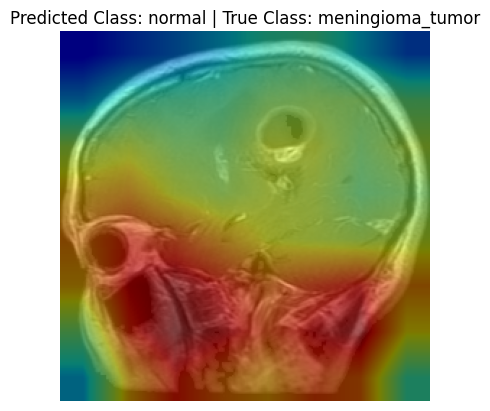

1
Label of image at index 1: 3
tensor([2], device='cuda:0')


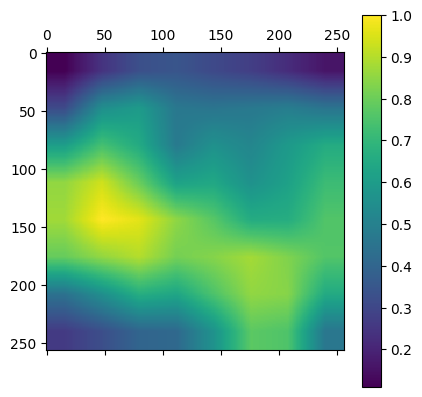

normal
pituitary_tumor


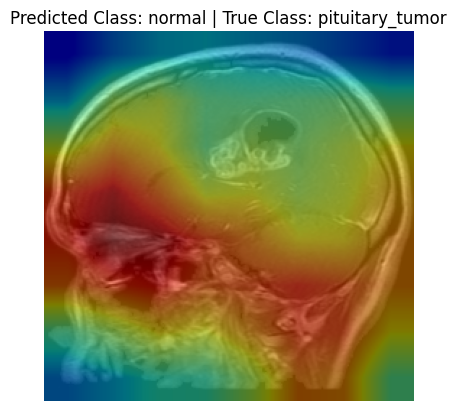

18
Label of image at index 18: 3
tensor([2], device='cuda:0')


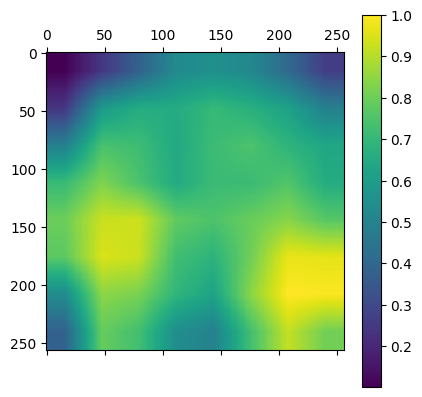

normal
pituitary_tumor


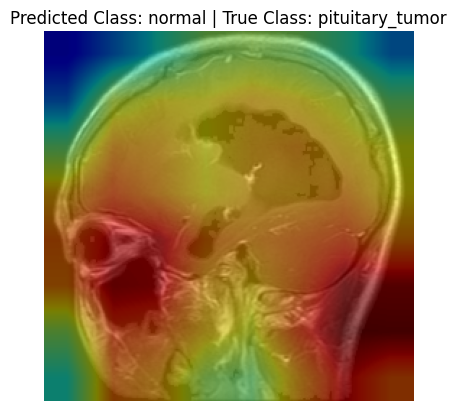

In [68]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = ResNet()
resnet.to(device)

num_images = len(test_loader.dataset)
print(num_images)
random_index = random.randint(0, num_images - 1)

# set the evaluation mode
_ = resnet.eval()
num_images_to_process = 10
available_indices = list(range(len(test_loader)))

for _ in range(num_images_to_process):
    specified_index = random.sample(available_indices, 1)[0]
    available_indices.remove(specified_index)
    print(specified_index)
    for idx, (images, labels) in enumerate(test_loader):
        if idx == specified_index:
            label_of_image = labels[0]  # Assuming you're dealing with a single image per batch
            print(f"Label of image at index {specified_index}: {label_of_image}")
            break

    img, _ = next(iter(test_loader))
    img = img.to(device)
    
    # Access the image at the specified index
    img = img[specified_index].unsqueeze(0) 

    # Forward pass to get predictions
    pred = resnet(img)
    predicted_class = pred.argmax(dim=1)
    print(predicted_class)
    
    # Compute loss only for predicted class
    loss = pred[:, predicted_class].sum()
    
    # Backward pass
    loss.backward()
    
    # Pull the gradients out of the model
    gradients = resnet.get_gradient()
    
    # Pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    
    # Get the activations of the last convolutional layer
    activations = resnet.get_activations(img).detach()
    
    # Weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    

    upsampled_heatmap = torch.nn.functional.interpolate(activations, size=(256, 256), mode='bilinear', align_corners=False)
    
    # Average the channels of the upsampled heatmap
    heatmap = torch.mean(upsampled_heatmap, dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Display the heatmap
    plt.matshow(heatmap)
    plt.colorbar()
    plt.show()

    # Create heatmap as PIL image
    heatmap_pil = Image.fromarray(np.uint8(plt.cm.jet(heatmap) * 255))

    # Convert the tensor image to a PIL image
    img_pil = transforms.ToPILImage()(img.squeeze(0).cpu())

    # Resize heatmap to match the image size
    heatmap_resized = heatmap_pil.resize((img_pil.width, img_pil.height), Image.ANTIALIAS)

    # Blend the heatmap onto the image with transparency
    blended = Image.blend(img_pil.convert("RGBA"), heatmap_resized.convert("RGBA"), alpha=0.5)

    # Display the superimposed image
    predicted_label = predicted_class[0]
    predicted_label = class_names[predicted_label]
    print(predicted_label)
    true_label = class_names[label_of_image]
    print(true_label)
    plt.imshow(blended)
    plt.title(f"Predicted Class: {predicted_label} | True Class: {true_label}")
    plt.axis('off')
    plt.show()
    
    del img, pred, heatmap, img_pil  # Delete tensors
    torch.cuda.empty_cache() 





Model Making for classification:

Classification Training:

Classification Testing:

Tumor Localization:

Visualization: